In [45]:
import numpy as np 
import os
import pandas as pd 
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder

import librosa
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers, activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils, to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from datetime import datetime 

from matplotlib import pyplot as plt

In [26]:
us8k_df = pd.read_pickle("us8k_df_mfcc_2.pkl")
us8k_df.head()

,feature,class,fold
0,"[-215.79301, 71.66612, -131.81377, -52.091328,...",dog_bark,5
1,"[-424.68677, 110.56227, -54.14824, 62.01074, -...",children_playing,5
2,"[-459.56467, 122.800354, -47.92471, 53.265694,...",children_playing,5
3,"[-414.55377, 102.896904, -36.66495, 54.180405,...",children_playing,5
4,"[-447.397, 115.0954, -53.809113, 61.608585, 1....",children_playing,5


In [40]:
us8k_df= us8k_df.rename(columns={'class': 'label'})
us8k_df.feature.shape

(8731,)

In [31]:
def init_model():
    # Construct model 
    model = Sequential()

    model.add(Dense(256, input_shape=(40,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [32]:
model = init_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               10496     
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_12 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [41]:
def train_test_split(fold_k, data, X_dim=(128, 128, 1)):
    X_train = np.stack(data[data.fold != fold_k].feature.to_list())
    X_test = np.stack(data[data.fold == fold_k].feature.to_list())

    y_train = data[data.fold != fold_k].label.to_list()
    y_test = data[data.fold == fold_k].label.to_list()
    le = LabelEncoder()
    y_train = to_categorical(le.fit_transform(y_train))
    y_test = to_categorical(le.fit_transform(y_test))



    
    return X_train, X_test, y_train, y_test

In [42]:
def process_fold(fold_k, data, epochs=100, num_batch_size=32):
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(fold_k, data)

    # init model
    model = init_model()

    # pre-training accuracy
    score = model.evaluate(X_test, y_test, batch_size=num_batch_size, verbose=0)
    print("Pre-training accuracy: %.4f%%\n" % (100 * score[1]))
    
    # train the model
    start = datetime.now()
    history = model.fit(X_train,y_train, epochs=epochs,validation_data=(X_test,y_test),batch_size=num_batch_size)
    end = datetime.now()
    print("Training completed in time: ", end - start, '\n')
    
    return history

In [43]:
def show_results(tot_history):
    """Show accuracy and loss graphs for train and test sets."""
    pngName = ['result/res1.png','res2.png','res3.png','res4.png','res5.png','res6.png','res7.png','res8.png','res9.png','res10.png']
    for i, history in enumerate(tot_history):
        print('\n({})'.format(i+1))
        fig = plt.figure()
        plt.figure(figsize=(15,5))

        plt.subplot(121)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.grid(linestyle='--')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplot(122)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.grid(linestyle='--')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')
            
        plt.savefig(pngName[i])
        
        file = open('result/result.txt','a')
        file.write('\n=========FOLD%s=========\n'% (i+1))
        file.write('\nMax validation accuracy: %.4f %%' % (np.max(history.history['val_accuracy']) * 100))
        file.write('\nMin validation loss: %.5f' % np.min(history.history['val_loss']))

        print('\tMax validation accuracy: %.4f %%' % (np.max(history.history['val_accuracy']) * 100))
        print('\tMin validation loss: %.5f' % np.min(history.history['val_loss']))

In [49]:
FOLD_K = 1

history1 = []

print('-'*80)
print("\n({})\n".format(FOLD_K))
    
history = process_fold(FOLD_K, us8k_df, epochs=100)
history1.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 2.5229%

Epoch 1/100
246/246 [==============================] - 1s 1ms/step - loss: 8.2572 - accuracy: 0.1965 - val_loss: 2.1724 - val_accuracy: 0.1709
Epoch 2/100
246/246 [==============================] - 0s 1ms/step - loss: 2.2265 - accuracy: 0.2462 - val_loss: 2.1094 - val_accuracy: 0.2775
Epoch 3/100
246/246 [==============================] - 0s 1ms/step - loss: 2.0064 - accuracy: 0.2812 - val_loss: 2.0029 - val_accuracy: 0.2787
Epoch 4/100
246/246 [==============================] - 0s 1ms/step - loss: 1.8580 - accuracy: 0.3338 - val_loss: 1.8996 - val_accuracy: 0.3016
Epoch 5/100
246/246 [==============================] - 0s 1ms/step - loss: 1.7166 - accuracy: 0.3978 - val_loss: 1.9219 - val_accuracy: 0.3131
Epoch 6/100
246/246 [==============================] - 0s 1ms/step - loss: 1.6053 - accuracy: 0.4354 - val_loss: 1.7638 - val_accuracy: 0.3544
Epoch 7/100
246/246 [==

In [50]:
FOLD_K = 2

print('-'*80)
print("\n({})\n".format(FOLD_K))
    
history = process_fold(FOLD_K, us8k_df, epochs=100)
history1.append(history)

--------------------------------------------------------------------------------

(2)

Pre-training accuracy: 11.2613%

Epoch 1/100
246/246 [==============================] - 1s 1ms/step - loss: 8.0121 - accuracy: 0.1953 - val_loss: 2.2001 - val_accuracy: 0.2083
Epoch 2/100
246/246 [==============================] - 0s 1ms/step - loss: 2.1926 - accuracy: 0.2412 - val_loss: 2.0978 - val_accuracy: 0.2320
Epoch 3/100
246/246 [==============================] - 0s 1ms/step - loss: 1.9856 - accuracy: 0.2944 - val_loss: 1.9100 - val_accuracy: 0.3829
Epoch 4/100
246/246 [==============================] - 0s 1ms/step - loss: 1.8463 - accuracy: 0.3427 - val_loss: 1.8026 - val_accuracy: 0.3818
Epoch 5/100
246/246 [==============================] - 0s 1ms/step - loss: 1.7151 - accuracy: 0.3974 - val_loss: 1.7860 - val_accuracy: 0.3221
Epoch 6/100
246/246 [==============================] - 0s 1ms/step - loss: 1.6173 - accuracy: 0.4338 - val_loss: 1.7874 - val_accuracy: 0.3423
Epoch 7/100
246/246 [=

In [51]:
FOLD_K = 3

print('-'*80)
print("\n({})\n".format(FOLD_K))
    
history = process_fold(FOLD_K, us8k_df, epochs=100)
history1.append(history)

--------------------------------------------------------------------------------

(3)

Pre-training accuracy: 16.0000%

Epoch 1/100
244/244 [==============================] - 1s 1ms/step - loss: 8.8025 - accuracy: 0.1791 - val_loss: 2.2451 - val_accuracy: 0.1589
Epoch 2/100
244/244 [==============================] - 0s 1ms/step - loss: 2.2372 - accuracy: 0.2303 - val_loss: 2.1263 - val_accuracy: 0.2292
Epoch 3/100
244/244 [==============================] - 0s 1ms/step - loss: 2.0573 - accuracy: 0.2794 - val_loss: 1.9901 - val_accuracy: 0.3286
Epoch 4/100
244/244 [==============================] - 0s 2ms/step - loss: 1.8822 - accuracy: 0.3385 - val_loss: 1.8576 - val_accuracy: 0.3784
Epoch 5/100
244/244 [==============================] - 0s 2ms/step - loss: 1.7787 - accuracy: 0.3689 - val_loss: 1.7280 - val_accuracy: 0.4065
Epoch 6/100
244/244 [==============================] - 0s 1ms/step - loss: 1.6638 - accuracy: 0.4119 - val_loss: 1.7194 - val_accuracy: 0.3978
Epoch 7/100
244/244 [=

In [52]:
FOLD_K = 4

print('-'*80)
print("\n({})\n".format(FOLD_K))
    
history = process_fold(FOLD_K, us8k_df, epochs=100)
history1.append(history)

--------------------------------------------------------------------------------

(4)

Pre-training accuracy: 16.0606%

Epoch 1/100
242/242 [==============================] - 1s 1ms/step - loss: 8.1292 - accuracy: 0.1939 - val_loss: 2.1717 - val_accuracy: 0.2566
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 2.1515 - accuracy: 0.2715 - val_loss: 2.0175 - val_accuracy: 0.3455
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.8789 - accuracy: 0.3409 - val_loss: 1.8672 - val_accuracy: 0.4030
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 1.7119 - accuracy: 0.4014 - val_loss: 1.7124 - val_accuracy: 0.4242
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 1.5811 - accuracy: 0.4408 - val_loss: 1.6146 - val_accuracy: 0.4697
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 1.4598 - accuracy: 0.4905 - val_loss: 1.5742 - val_accuracy: 0.4737
Epoch 7/100
242/242 [=

In [53]:
FOLD_K = 5

print('-'*80)
print("\n({})\n".format(FOLD_K))
    
history = process_fold(FOLD_K, us8k_df, epochs=100)
history1.append(history)

--------------------------------------------------------------------------------

(5)

Pre-training accuracy: 16.6667%

Epoch 1/100
244/244 [==============================] - 1s 1ms/step - loss: 7.9094 - accuracy: 0.1987 - val_loss: 2.2676 - val_accuracy: 0.1763
Epoch 2/100
244/244 [==============================] - 0s 1ms/step - loss: 2.1770 - accuracy: 0.2591 - val_loss: 2.1067 - val_accuracy: 0.2981
Epoch 3/100
244/244 [==============================] - 0s 1ms/step - loss: 1.9904 - accuracy: 0.3017 - val_loss: 1.9363 - val_accuracy: 0.2981
Epoch 4/100
244/244 [==============================] - 0s 1ms/step - loss: 1.8396 - accuracy: 0.3493 - val_loss: 1.8136 - val_accuracy: 0.3665
Epoch 5/100
244/244 [==============================] - 0s 1ms/step - loss: 1.7255 - accuracy: 0.3846 - val_loss: 1.6846 - val_accuracy: 0.4135
Epoch 6/100
244/244 [==============================] - 0s 1ms/step - loss: 1.6272 - accuracy: 0.4218 - val_loss: 1.5525 - val_accuracy: 0.4359
Epoch 7/100
244/244 [=

In [54]:
FOLD_K = 6

print('-'*80)
print("\n({})\n".format(FOLD_K))
    
history = process_fold(FOLD_K, us8k_df, epochs=100)
history1.append(history)

--------------------------------------------------------------------------------

(6)

Pre-training accuracy: 12.6367%

Epoch 1/100
248/248 [==============================] - 1s 1ms/step - loss: 9.0078 - accuracy: 0.2047 - val_loss: 2.1777 - val_accuracy: 0.2260
Epoch 2/100
248/248 [==============================] - 0s 1ms/step - loss: 2.1806 - accuracy: 0.2467 - val_loss: 2.0456 - val_accuracy: 0.2382
Epoch 3/100
248/248 [==============================] - 0s 1ms/step - loss: 1.9305 - accuracy: 0.3137 - val_loss: 1.9012 - val_accuracy: 0.3086
Epoch 4/100
248/248 [==============================] - 0s 1ms/step - loss: 1.8115 - accuracy: 0.3567 - val_loss: 1.8226 - val_accuracy: 0.3269
Epoch 5/100
248/248 [==============================] - 0s 1ms/step - loss: 1.6841 - accuracy: 0.4050 - val_loss: 1.7860 - val_accuracy: 0.3171
Epoch 6/100
248/248 [==============================] - 0s 1ms/step - loss: 1.5788 - accuracy: 0.4456 - val_loss: 1.7274 - val_accuracy: 0.3718
Epoch 7/100
248/248 [=

In [55]:
FOLD_K = 7

print('-'*80)
print("\n({})\n".format(FOLD_K))
    
history = process_fold(FOLD_K, us8k_df, epochs=100)
history1.append(history)

--------------------------------------------------------------------------------

(7)

Pre-training accuracy: 11.9332%

Epoch 1/100
247/247 [==============================] - 1s 1ms/step - loss: 8.3338 - accuracy: 0.2040 - val_loss: 2.1787 - val_accuracy: 0.2267
Epoch 2/100
247/247 [==============================] - 0s 1ms/step - loss: 2.1305 - accuracy: 0.2764 - val_loss: 2.0793 - val_accuracy: 0.2995
Epoch 3/100
247/247 [==============================] - 0s 1ms/step - loss: 1.9243 - accuracy: 0.3223 - val_loss: 1.9304 - val_accuracy: 0.3723
Epoch 4/100
247/247 [==============================] - 0s 1ms/step - loss: 1.7367 - accuracy: 0.3922 - val_loss: 1.7644 - val_accuracy: 0.4033
Epoch 5/100
247/247 [==============================] - 0s 1ms/step - loss: 1.6107 - accuracy: 0.4349 - val_loss: 1.6524 - val_accuracy: 0.4773
Epoch 6/100
247/247 [==============================] - 0s 1ms/step - loss: 1.4936 - accuracy: 0.4731 - val_loss: 1.6194 - val_accuracy: 0.4761
Epoch 7/100
247/247 [=

In [56]:
FOLD_K = 8

print('-'*80)
print("\n({})\n".format(FOLD_K))
    
history = process_fold(FOLD_K, us8k_df, epochs=100)
history1.append(history)

--------------------------------------------------------------------------------

(8)

Pre-training accuracy: 15.5087%

Epoch 1/100
248/248 [==============================] - 1s 1ms/step - loss: 7.8284 - accuracy: 0.1890 - val_loss: 2.1176 - val_accuracy: 0.3015
Epoch 2/100
248/248 [==============================] - 0s 1ms/step - loss: 2.1807 - accuracy: 0.2617 - val_loss: 1.9129 - val_accuracy: 0.3660
Epoch 3/100
248/248 [==============================] - 0s 1ms/step - loss: 1.9558 - accuracy: 0.3285 - val_loss: 1.6503 - val_accuracy: 0.4529
Epoch 4/100
248/248 [==============================] - 0s 1ms/step - loss: 1.7866 - accuracy: 0.3770 - val_loss: 1.4817 - val_accuracy: 0.5211
Epoch 5/100
248/248 [==============================] - 0s 1ms/step - loss: 1.5985 - accuracy: 0.4503 - val_loss: 1.4310 - val_accuracy: 0.5422
Epoch 6/100
248/248 [==============================] - 0s 1ms/step - loss: 1.4994 - accuracy: 0.4820 - val_loss: 1.3783 - val_accuracy: 0.5558
Epoch 7/100
248/248 [=

In [57]:
FOLD_K = 9

print('-'*80)
print("\n({})\n".format(FOLD_K))
    
history = process_fold(FOLD_K, us8k_df, epochs=100)
history1.append(history)

--------------------------------------------------------------------------------

(9)

Pre-training accuracy: 12.1324%

Epoch 1/100
248/248 [==============================] - 1s 1ms/step - loss: 8.3823 - accuracy: 0.1893 - val_loss: 2.0174 - val_accuracy: 0.2500
Epoch 2/100
248/248 [==============================] - 0s 1ms/step - loss: 2.1488 - accuracy: 0.2752 - val_loss: 1.8693 - val_accuracy: 0.3517
Epoch 3/100
248/248 [==============================] - 0s 1ms/step - loss: 1.9264 - accuracy: 0.3358 - val_loss: 1.7012 - val_accuracy: 0.3897
Epoch 4/100
248/248 [==============================] - 0s 1ms/step - loss: 1.7504 - accuracy: 0.3856 - val_loss: 1.5750 - val_accuracy: 0.4632
Epoch 5/100
248/248 [==============================] - 0s 1ms/step - loss: 1.6321 - accuracy: 0.4287 - val_loss: 1.5466 - val_accuracy: 0.5000
Epoch 6/100
248/248 [==============================] - 0s 1ms/step - loss: 1.5065 - accuracy: 0.4780 - val_loss: 1.4443 - val_accuracy: 0.5306
Epoch 7/100
248/248 [=

In [58]:
FOLD_K = 10

print('-'*80)
print("\n({})\n".format(FOLD_K))
    
history = process_fold(FOLD_K, us8k_df, epochs=100)
history1.append(history)

--------------------------------------------------------------------------------

(10)

Pre-training accuracy: 11.2306%

Epoch 1/100
247/247 [==============================] - 1s 1ms/step - loss: 7.4940 - accuracy: 0.2046 - val_loss: 2.1065 - val_accuracy: 0.2832
Epoch 2/100
247/247 [==============================] - 0s 1ms/step - loss: 2.1674 - accuracy: 0.2683 - val_loss: 1.9802 - val_accuracy: 0.3835
Epoch 3/100
247/247 [==============================] - 0s 1ms/step - loss: 1.9437 - accuracy: 0.3197 - val_loss: 1.7740 - val_accuracy: 0.4779
Epoch 4/100
247/247 [==============================] - 0s 1ms/step - loss: 1.7803 - accuracy: 0.3752 - val_loss: 1.6406 - val_accuracy: 0.5281
Epoch 5/100
247/247 [==============================] - 0s 1ms/step - loss: 1.6353 - accuracy: 0.4296 - val_loss: 1.5360 - val_accuracy: 0.5376
Epoch 6/100
247/247 [==============================] - 0s 1ms/step - loss: 1.4822 - accuracy: 0.4834 - val_loss: 1.5082 - val_accuracy: 0.5400
Epoch 7/100
247/247 [


(1)
	Max validation accuracy: 52.4083 %
	Min validation loss: 1.74324

(2)
	Max validation accuracy: 54.2793 %
	Min validation loss: 1.68261

(3)
	Max validation accuracy: 47.5676 %
	Min validation loss: 1.60290

(4)
	Max validation accuracy: 55.4545 %
	Min validation loss: 1.45392

(5)
	Max validation accuracy: 59.8291 %
	Min validation loss: 1.34176

(6)
	Max validation accuracy: 53.4629 %
	Min validation loss: 1.54410

(7)
	Max validation accuracy: 59.7852 %
	Min validation loss: 1.19953

(8)
	Max validation accuracy: 61.4144 %
	Min validation loss: 1.33897

(9)
	Max validation accuracy: 60.9069 %
	Min validation loss: 1.36269

(10)
	Max validation accuracy: 63.2019 %
	Min validation loss: 1.19958


<Figure size 432x288 with 0 Axes>

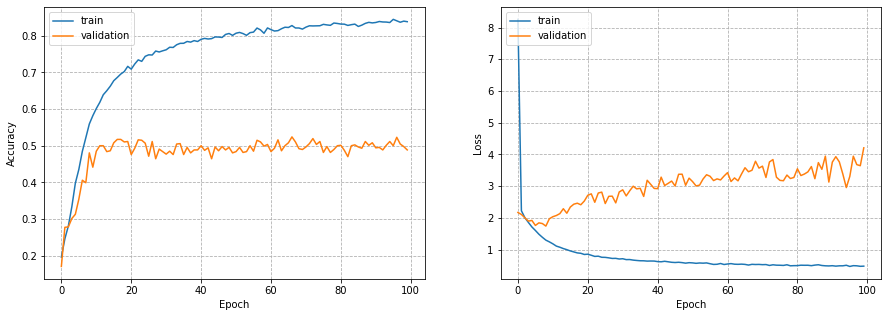

<Figure size 432x288 with 0 Axes>

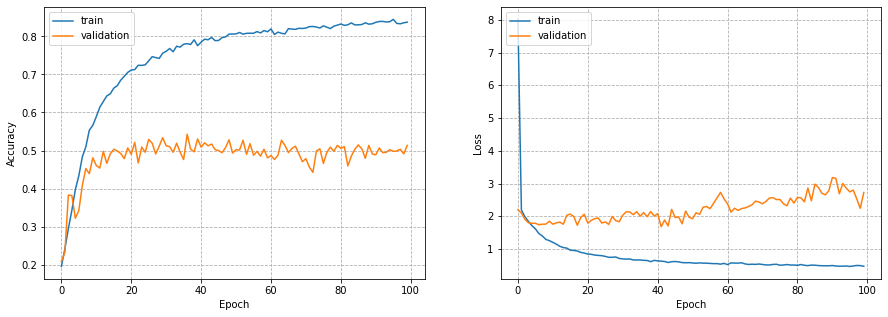

<Figure size 432x288 with 0 Axes>

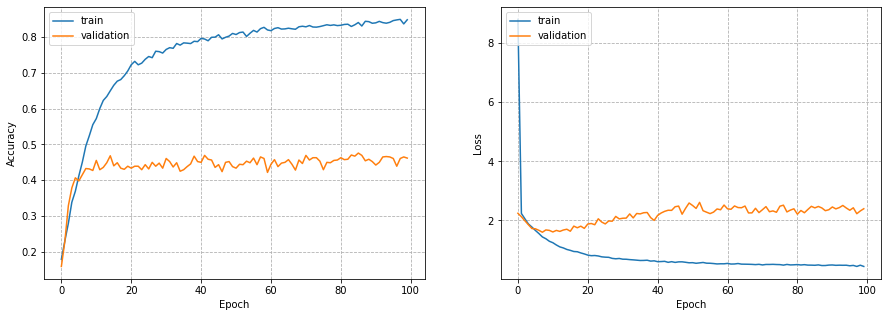

<Figure size 432x288 with 0 Axes>

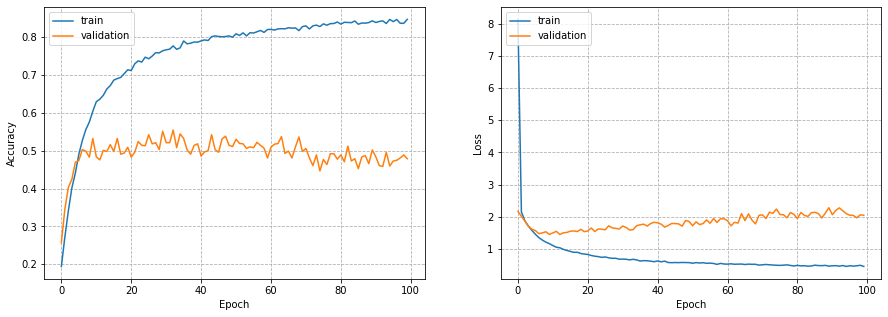

<Figure size 432x288 with 0 Axes>

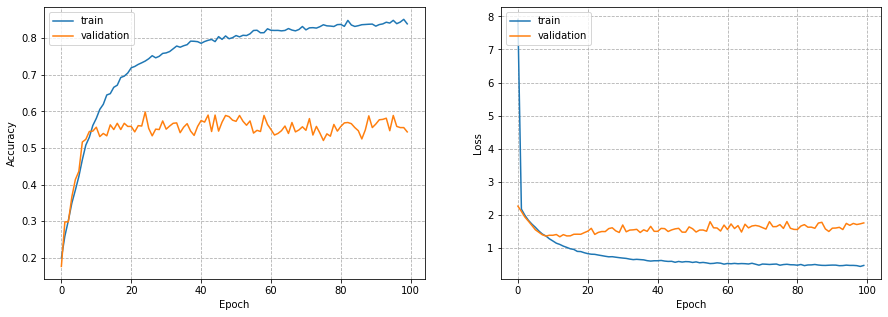

<Figure size 432x288 with 0 Axes>

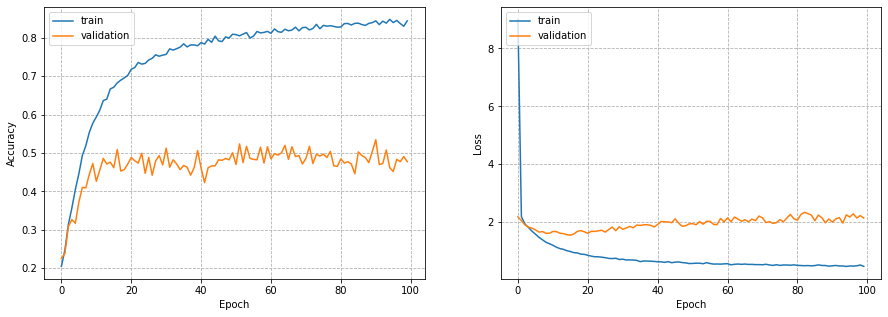

<Figure size 432x288 with 0 Axes>

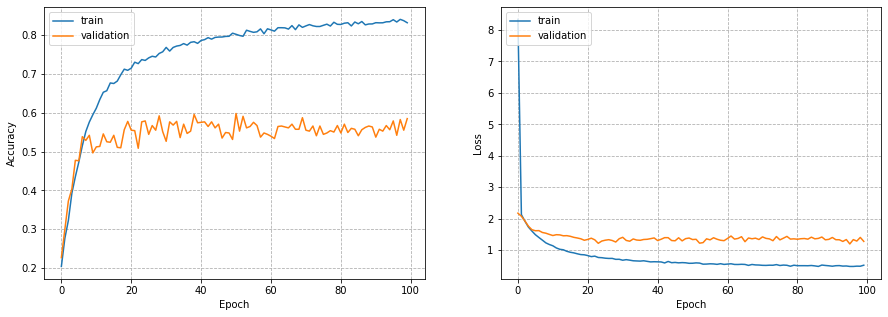

<Figure size 432x288 with 0 Axes>

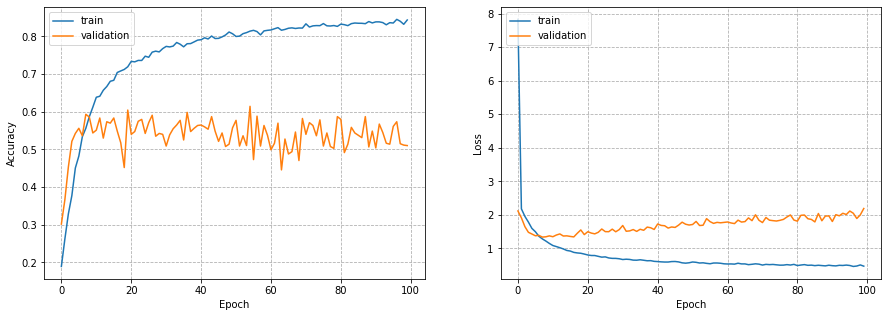

<Figure size 432x288 with 0 Axes>

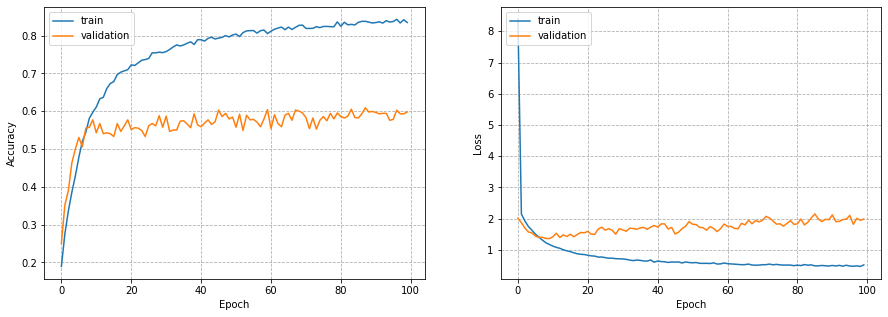

<Figure size 432x288 with 0 Axes>

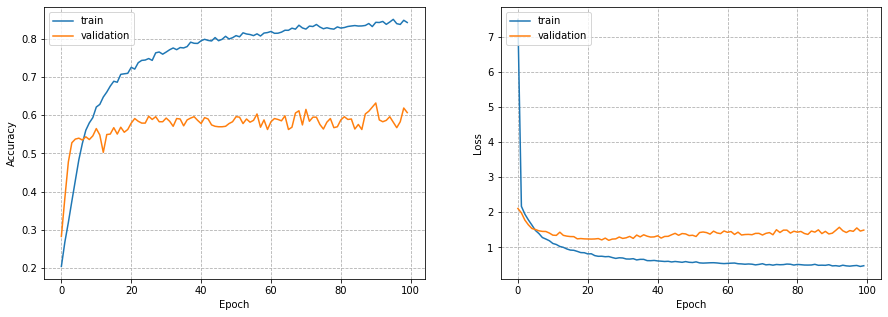

In [59]:
show_results(history1)